In [1]:
%pip install -q matplotlib numpy sympy scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sympy
import scipy
import numpy as np
import matplotlib.pyplot as plt

![Circuit](fig/circuit.png)

Define your variables

In [3]:
R_1, R_2, L, C, I_1, I_2, I_3, U, s, t = sympy.symbols('R_1, R_2, L, C, I_1, I_2, I_3, U, s, t')

Setup your equations based on loop laws.

In [4]:
eq1 = U - R_1*I_1 - (1/C)*(I_1 - I_2)/s
eq1

-I_1*R_1 + U - (I_1 - I_2)/(C*s)

In [5]:
eq2 = R_2*I_2 + L*I_2*s - (1/(C*s))*(I_1 - I_2)
eq2

I_2*L*s + I_2*R_2 - (I_1 - I_2)/(C*s)

Solve your equations.

In [6]:
sol = sympy.solve([eq1, eq2], [I_1, I_2])
sol[I_1]

(C*L*U*s**2 + C*R_2*U*s + U)/(C*L*R_1*s**2 + C*R_1*R_2*s + L*s + R_1 + R_2)

In [7]:
sol[I_2]

U/(C*L*R_1*s**2 + C*R_1*R_2*s + L*s + R_1 + R_2)

Find the transfer function for the voltage drop across the inductor.

In [8]:
G = (-L*s*sol[I_2])/U
G

-L*s/(C*L*R_1*s**2 + C*R_1*R_2*s + L*s + R_1 + R_2)

In [9]:
component_values = {
    R_1: 1,
    R_2: 5,
    L: 1,
    C: sympy.Rational(1, 3)
}

In [10]:
G1 = G.subs(component_values)
G1

-s/(s**2/3 + 8*s/3 + 6)

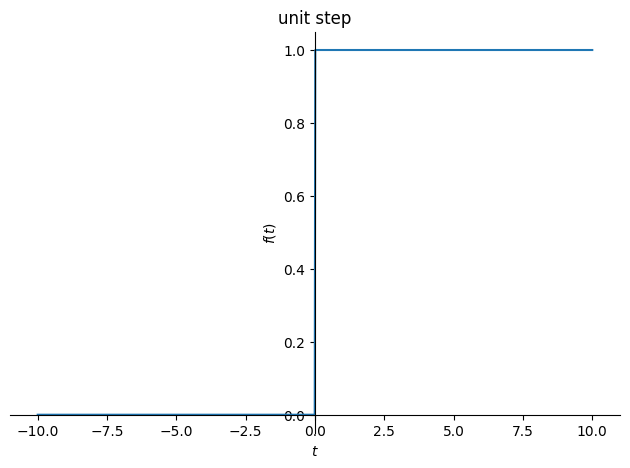

In [11]:
sympy.plot(sympy.Heaviside(t), title='unit step')

In [12]:
g = sympy.inverse_laplace_transform(sympy.apart(G1), s, t)
sympy.Eq(sympy.Function('g')(t), g)

Eq(g(t), -3*(-2*sqrt(2)*exp(-4*t)*sin(sqrt(2)*t) + exp(-4*t)*cos(sqrt(2)*t))*Heaviside(t))

In [13]:
G1

-s/(s**2/3 + 8*s/3 + 6)

In [14]:
sympy.simplify(G1)

-3*s/(s**2 + 8*s + 18)

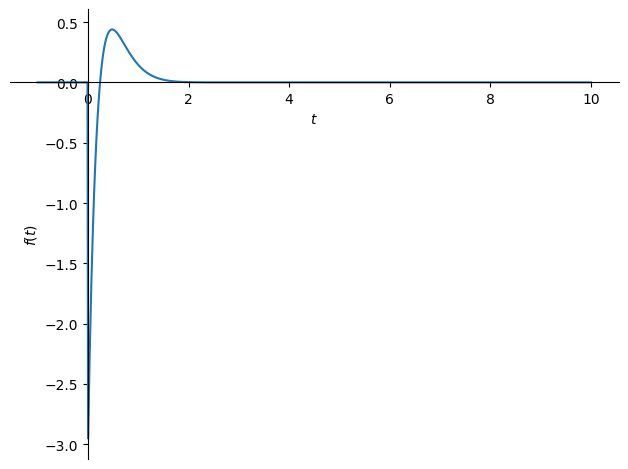

In [15]:
sympy.plot(g, (t, -1, 10))

In [16]:
num, den = sympy.fraction(G1)
sympy.Poly(s**2 + 2*s  +3, s).all_coeffs()

[1, 2, 3]

In [17]:
t_vals = np.linspace(0, 4, 1000)
sympy.lambdify([t], g)(t_vals)

array([-1.50000000e+00, -2.90500296e+00, -2.81217563e+00, -2.72147598e+00,
       -2.63286270e+00, -2.54629517e+00, -2.46173350e+00, -2.37913846e+00,
       -2.29847152e+00, -2.21969480e+00, -2.14277108e+00, -2.06766380e+00,
       -1.99433702e+00, -1.92275544e+00, -1.85288437e+00, -1.78468974e+00,
       -1.71813806e+00, -1.65319643e+00, -1.58983256e+00, -1.52801468e+00,
       -1.46771163e+00, -1.40889277e+00, -1.35152802e+00, -1.29558783e+00,
       -1.24104318e+00, -1.18786557e+00, -1.13602700e+00, -1.08549999e+00,
       -1.03625753e+00, -9.88273122e-01, -9.41520727e-01, -8.95974786e-01,
       -8.51610201e-01, -8.08402330e-01, -7.66326978e-01, -7.25360394e-01,
       -6.85479259e-01, -6.46660679e-01, -6.08882184e-01, -5.72121714e-01,
       -5.36357617e-01, -5.01568638e-01, -4.67733919e-01, -4.34832985e-01,
       -4.02845743e-01, -3.71752474e-01, -3.41533827e-01, -3.12170810e-01,
       -2.83644791e-01, -2.55937484e-01, -2.29030949e-01, -2.02907584e-01,
       -1.77550118e-01, -

In [18]:
? sympy.lambdify

Signature:
 sympy.lambdify(
    args,
    expr,
    modules=None,
    printer=None,
    use_imps=True,
    dummify=False,
    cse=False,
    docstring_limit=1000,
)
Docstring:
Convert a SymPy expression into a function that allows for fast
numeric evaluation.

.. warning::
   This function uses ``exec``, and thus should not be used on
   unsanitized input.

.. deprecated:: 1.7
   Passing a set for the *args* parameter is deprecated as sets are
   unordered. Use an ordered iterable such as a list or tuple.

Explanation

For example, to convert the SymPy expression ``sin(x) + cos(x)`` to an
equivalent NumPy function that numerically evaluates it:

>>> from sympy import sin, cos, symbols, lambdify
>>> import numpy as np
>>> x = symbols('x')
>>> expr = sin(x) + cos(x)
>>> expr
sin(x) + cos(x)
>>> f = lambdify(x, expr, 'numpy')
>>> a = np.array([1, 2])
>>> f(a)
[1.38177329 0.49315059]

The primary purpose of this function is to provide a bridge from SymPy
expressions to numerical libraries 

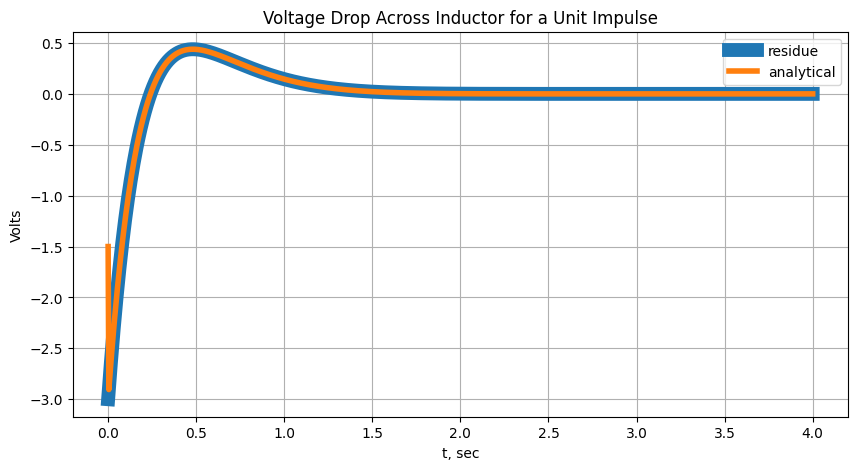

In [19]:
def sympy_vs_numerical():
    t_vals = np.linspace(0, 4, 1000)
    
    dirac_delta = lambda t: scipy.signal.unit_impulse(len(t))
    unit_step = lambda t: np.heaviside(t, 1)
    
    f_eval = sympy.lambdify([t], g)


    num, den = sympy.fraction(G1)
    num_coeffs = sympy.Poly(num, s).all_coeffs()
    den_coeffs = sympy.Poly(den, s).all_coeffs()
    
    r, p, k = scipy.signal.residue(num_coeffs, den_coeffs)
    
    y = 0
    
    if len(k) > 0:
        y = k[0]*dirac_delta(t_vals)

    for i in range(len(r)):
        y += r[i]*np.exp(p[i]*t_vals)

    assert np.linalg.norm(np.imag(y)) < 1e-5 # should have small imaginary part
    y = np.real(y)
    plt.figure(figsize=(10, 5))
    plt.plot(t_vals, y, linewidth=10, label='residue')
    plt.plot(t_vals, f_eval(t_vals), linewidth=4, label='analytical')
    plt.grid()
    plt.title('Voltage Drop Across Inductor for a Unit Impulse')
    plt.ylabel('Volts')
    plt.xlabel('t, sec')
    plt.legend()
    
sympy_vs_numerical()

$$ y(t) = \int_0^{t} g(t) u(t - \tau) d\tau$$